# Using Machine Learning to determine photometric redshift

## Lecture given by Miguel Angel Aragon, del Instituto de Astronomia de la UNAM, sede de Ensenada.


## This Notebook can be run in Google Colab, where all the needed libbraries are already installed.
## You can use the CPU or GPU configuration, it almost takes the same time to run.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input
import seaborn as sns


## Download the data from the github repository

In [2]:
#- redshift, photo-z, m_u, m_g, m_r, m_i, m_z, petro50, petro90
try:
  sdss_df = pd.read_csv('DR9_photo-z-small.csv.gz')
except:
  ! wget https://github.com/Morisset/Python-lectures-Notebooks/raw/master/Notebooks/DR9_photo-z-small.csv.gz
  sdss_df = np.load('DR9_photo-z-small.csv.gz')

In [3]:
# Shape of the data
sdss_df.shape

(100000, 9)

In [4]:
sdss_df.describe()

,redshift,photo-z,m_u,m_g,m_r,m_i,m_z,petro50,petro90
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.404275,0.396646,22.651264,20.756488,19.317084,18.558377,18.177145,1.766778,4.568383
std,0.192560,0.185628,2.121546,1.764338,1.490486,1.267077,1.234728,2.104765,3.899772
min,0.000026,-0.000526,13.828072,12.263971,11.475709,10.966851,10.571234,0.070384,0.101272
25%,0.239152,0.241232,21.291794,19.535502,18.234928,17.699094,17.367150,1.192964,2.952616
50%,0.453396,0.441121,22.731034,21.316974,19.803043,18.959131,18.528835,1.506105,3.983968
75%,0.555304,0.540144,24.166098,22.075726,20.504852,19.545900,19.107799,1.959224,5.369060
max,1.002166,0.894627,29.379000,29.336216,27.810760,30.711807,28.203093,163.005220,237.316090


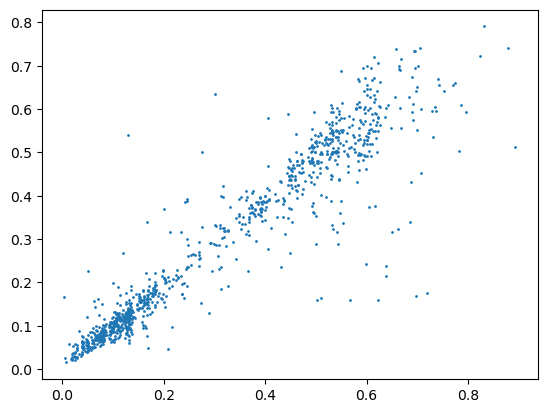

In [5]:
plt.scatter(sdss_df['redshift'][:1000], sdss_df['photo-z'][:1000], s=1);

In [6]:
# Adding log, more efficient to determine redshift
sdss_df['log_petro50'] = np.log10(sdss_df['petro50'])
sdss_df['log_petro90'] = np.log10(sdss_df['petro90'])

# Selection of the used columns
X_columns = ['m_u', 
             'm_g', 
             'm_r', 
             'm_i', 
             'm_z', 
#             'petro50', 
             'log_petro90']
             
y_columns = ['redshift']

## Split the data set into training and testing

In [7]:
train = sdss_df.sample(frac=0.9, random_state=32) #random state is a seed value
test = sdss_df.drop(train.index)

X_train = train[X_columns]
y_train = train[y_columns]

X_test = test[X_columns]
y_test = test[y_columns]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

n_X = X_train.shape[1]

(90000, 6) (90000, 1) (10000, 6) (10000, 1)


## Compare the redshift and the photo-z columns:

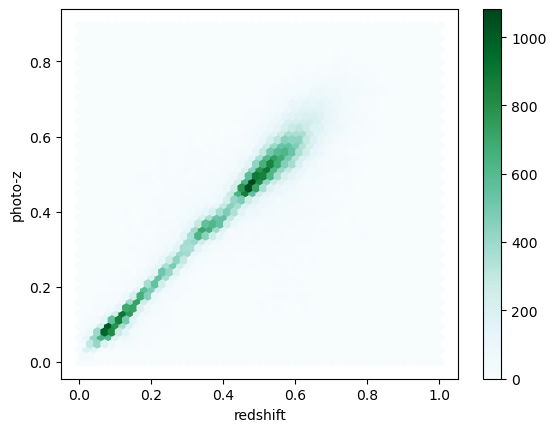

In [8]:
sdss_df.plot.hexbin('redshift', 'photo-z', gridsize=50);

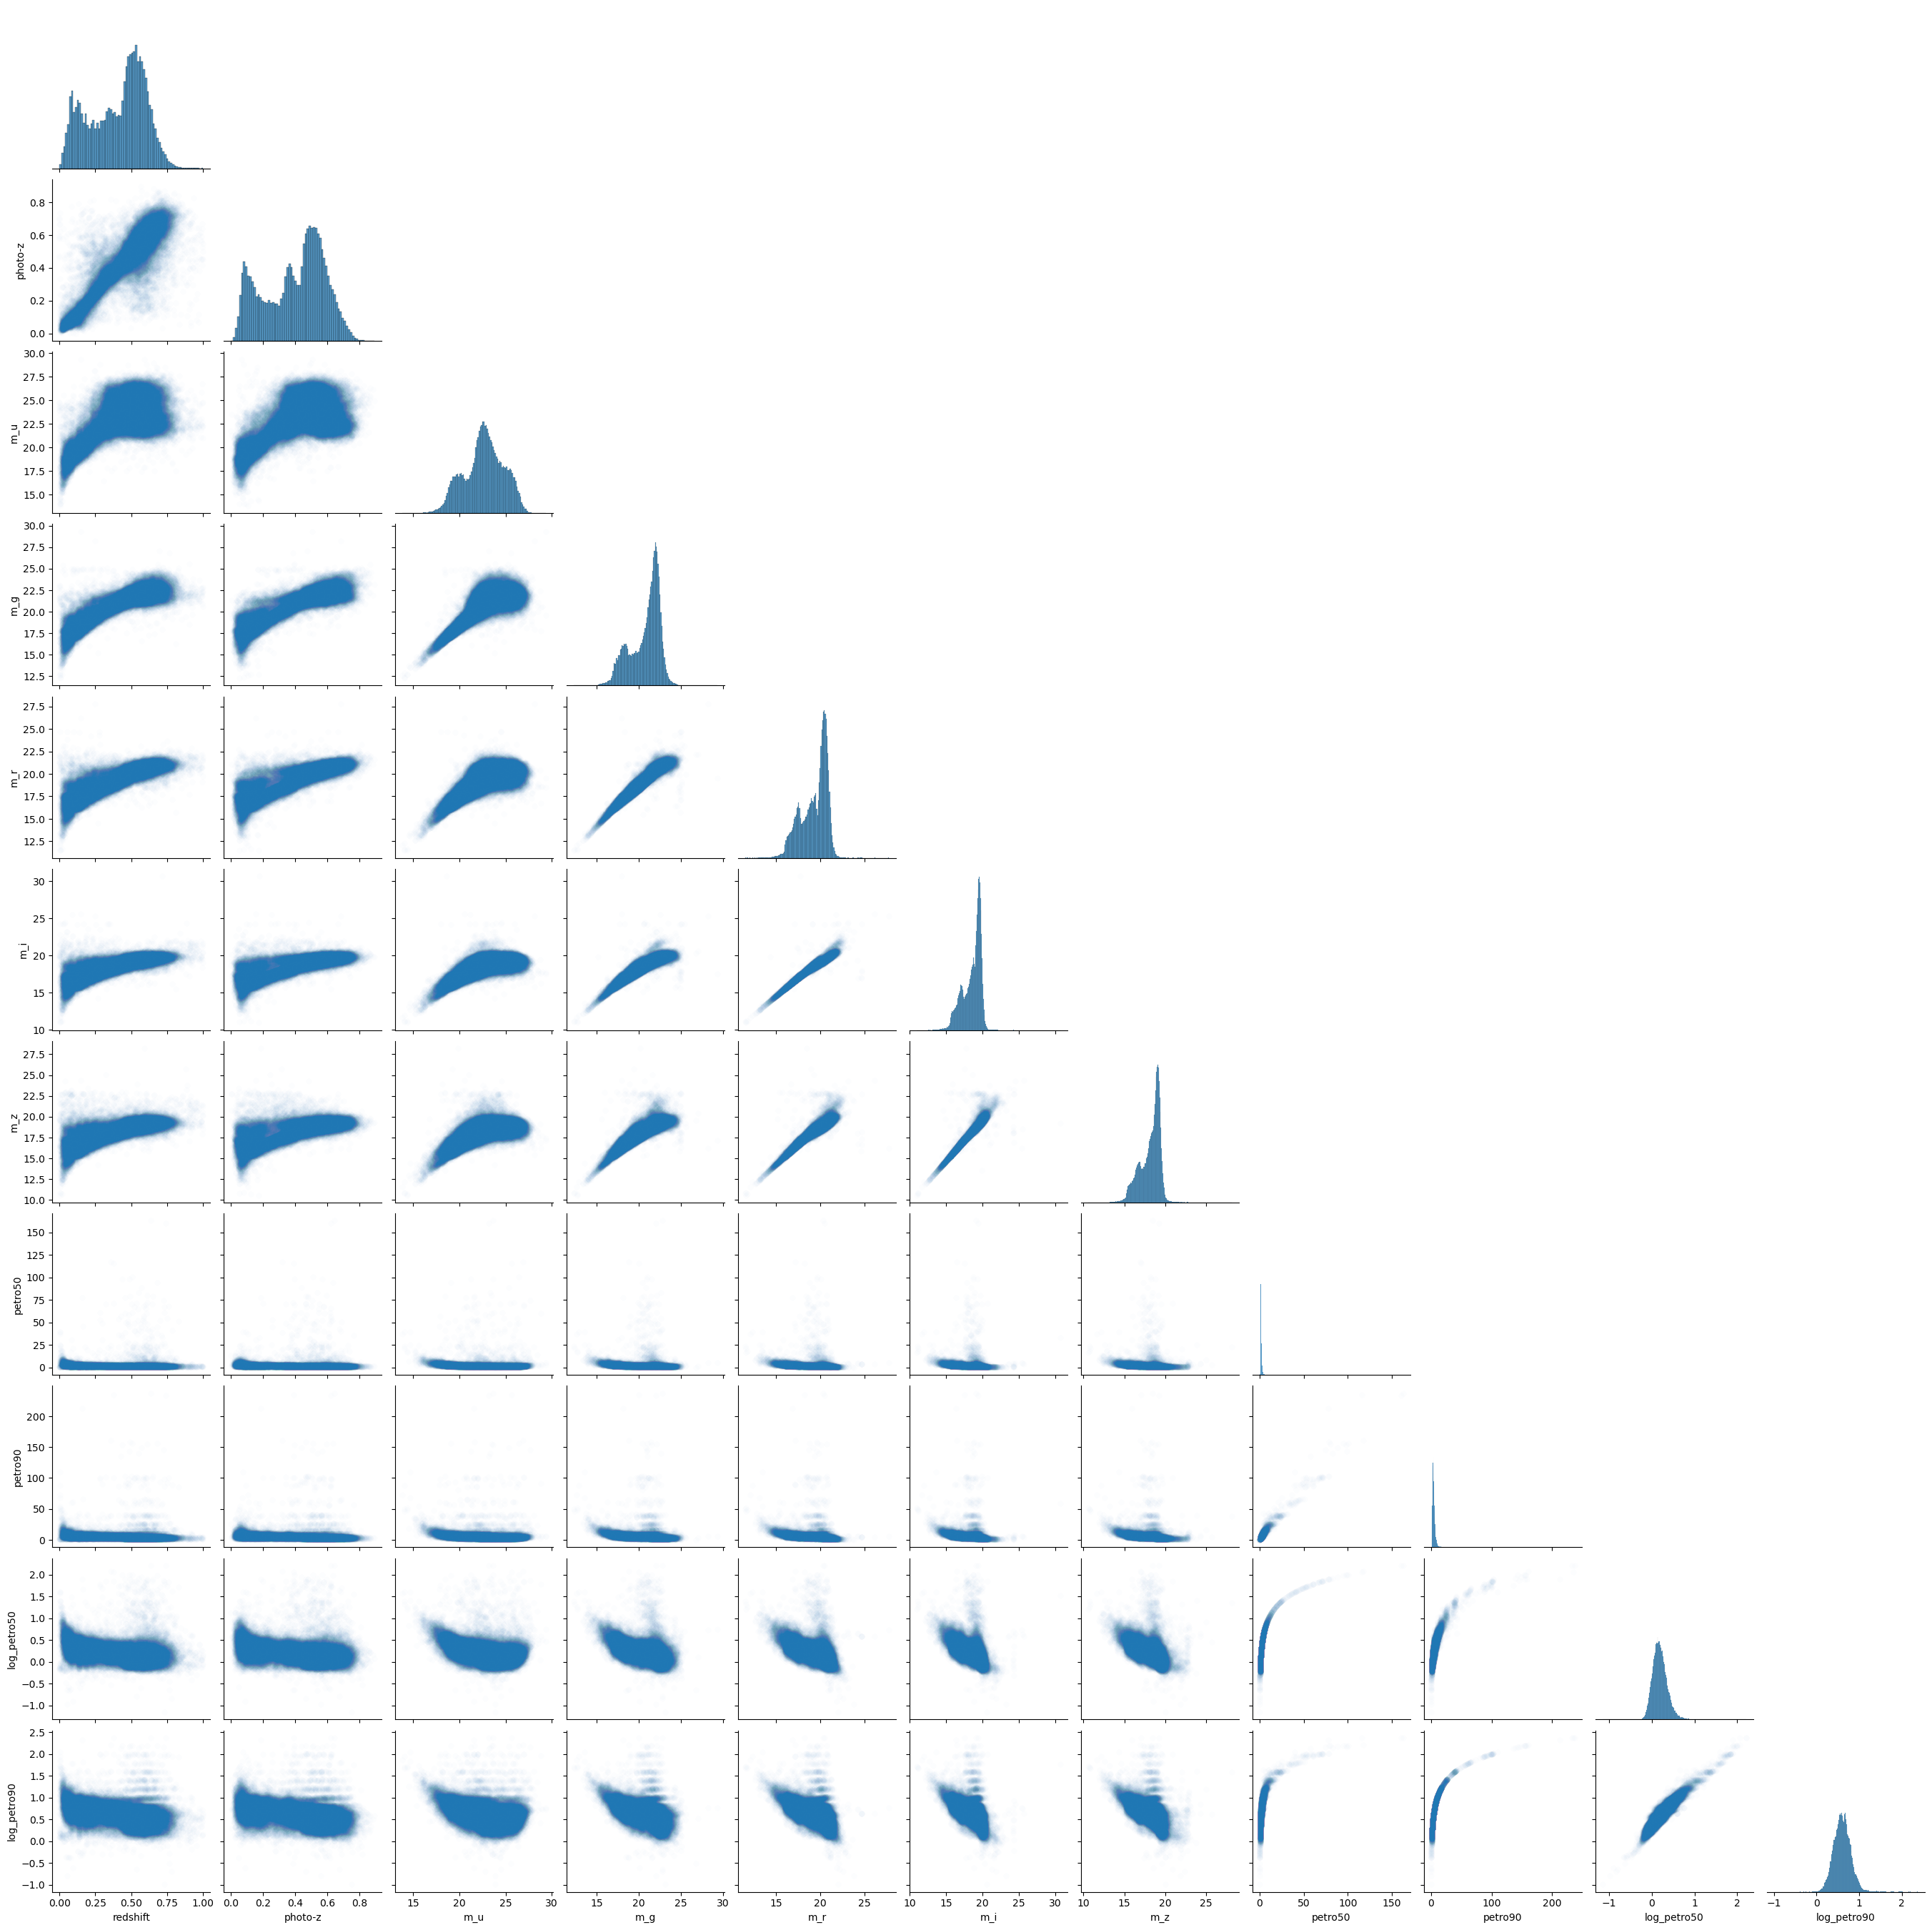

In [9]:
pp = sns.pairplot(sdss_df, plot_kws=dict(alpha=0.01), corner=True)

## Build the Artificial Neuron Network

In [10]:
model = Sequential()

model.add(Input(shape=(n_X,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

## Train the Neuron Network

In [12]:
ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
model.fit(ds, epochs=20, verbose=1)

Epoch 1/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 377us/step - loss: 0.0048 - mse: 0.0048
Epoch 2/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step - loss: 0.0048 - mse: 0.0048
Epoch 3/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 326us/step - loss: 0.0047 - mse: 0.0047
Epoch 4/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 348us/step - loss: 0.0047 - mse: 0.0047
Epoch 5/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 360us/step - loss: 0.0047 - mse: 0.0047
Epoch 6/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step - loss: 0.0046 - mse: 0.0046
Epoch 7/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step - loss: 0.0046 - mse: 0.0046
Epoch 8/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 330us/step - loss: 0.0046 - mse: 0.0046
Epoch 9/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 360us/step - loss: 0.0046 - mse: 0.0046
Epoch 10/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 345us/step - loss: 0.0045 - mse: 0.0045
Epoch 11/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 349us/step - loss: 0.0045 - mse: 0.0045
Epoch 12/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 329us/step - loss

## Predict the redshift for the test set

In [13]:
y_pred = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


## Compare predictions with "real" values from the test set

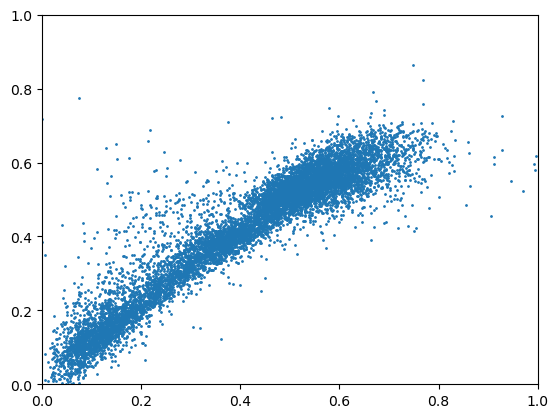

In [14]:
f, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=1)
ax.set_xlim(0,1)
ax.set_ylim(0,1);

## Standart deviation of the difference between prediction and real values

In [29]:
print(np.std(y_test - y_pred))

redshift    0.070874
dtype: float32


/Users/christophemorisset/anaconda3/envs/Python_Lecture/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
